# Virtual data set (VDS) reference file for SCATSAT1_ESDR_L2_WIND_STRESS_V1.1 using Virtualizarr

Saves VDS as parquet file. SCATSAT1_ESDR_L2_WIND_STRESS_V1.1 is an L2 data set with no time dimension, so this is an example of saving along a newly created dimension.

In [32]:
# Built-in packages
import os
import sys
import shutil
from typing import Optional

# Filesystem management 
import fsspec
import earthaccess
import icechunk

# Data handling
import numpy as np
import xarray as xr
from virtualizarr import open_virtual_dataset
import pandas as pd

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client
import coiled

# Other
import matplotlib.pyplot as plt

## 1. Get Data File S3 endpoints in Earthdata Cloud

In [5]:
# Get Earthdata creds
earthaccess.login()

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


In [6]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [7]:
# Locate CCMP file information / metadata:
granule_info = earthaccess.search_data(
    short_name="SCATSAT1_ESDR_L2_WIND_STRESS_V1.1",
    )

In [8]:
# Get S3 endpoints for all files:
data_s3links = [g.data_links(access="direct")[0] for g in granule_info]
print(len(data_s3links))
data_s3links[0:3]

13145


['s3://podaac-ops-cumulus-protected/SCATSAT1_ESDR_L2_WIND_STRESS_V1.1/2018/091/measures_esdr_scatsat_l2_wind_stress_08002_v1.1_s20180401-011908-e20180401-025826.nc',
 's3://podaac-ops-cumulus-protected/SCATSAT1_ESDR_L2_WIND_STRESS_V1.1/2018/091/measures_esdr_scatsat_l2_wind_stress_08003_v1.1_s20180401-025826-e20180401-043745.nc',
 's3://podaac-ops-cumulus-protected/SCATSAT1_ESDR_L2_WIND_STRESS_V1.1/2018/091/measures_esdr_scatsat_l2_wind_stress_08004_v1.1_s20180401-043745-e20180401-061703.nc']

## 2. Generate single-orbit reference files

One file per orbit, so one reference file per orbit.

In [9]:
n_files_process = 1000

In [10]:
# This will be assigned to 'loadable_variables' and needs to be modified per the specific 
# coord names of the data set:
coord_vars = ["lat","lon"]

In [11]:
print("CPU count =", multiprocessing.cpu_count())

CPU count = 32


In [12]:
reader_opts = {"storage_options": fs.storage_options} # S3 filesystem creds from previous section.

In [13]:
# Start up cluster and print some information about it:
client = Client(n_workers=30, threads_per_worker=1)
print(client.cluster)
print("View any work being done on the cluster here", client.dashboard_link)

LocalCluster(b062e43d, 'tcp://127.0.0.1:46875', workers=30, threads=30, memory=122.30 GiB)
View any work being done on the cluster here https://cluster-yymvs.dask.host/jupyter/proxy/8787/status


In [14]:
%%time
# Create individual references:
open_vds_par = delayed(open_virtual_dataset)
tasks = [
    open_vds_par(p, indexes={}, reader_options=reader_opts, loadable_variables=coord_vars) 
    for p in data_s3links[:n_files_process]
    ]
virtual_ds_list = list(da.compute(*tasks)) # The xr.combine_nested() function below needs a list rather than a tuple.

CPU times: user 25.5 s, sys: 7.52 s, total: 33 s
Wall time: 1min 27s


In [15]:
len(virtual_ds_list)

1000

## 3. Generate combined reference file along a newly created time dimension

The dimension will be "orbit start time", so get the start time from each file using the granule metadata. Convert those times into cf-compliant formats (e.g. "second since ..."). 

## 3.1 Dummy time dimension

In [16]:
## The dimension will be "orbit start time", so get the start time from each file using the granule metadata:

basetime_str = "1970-01-01T00:00:00Z" # times will be measured in seconds since this basetime. 

orbit_starttime_list = []
for g in granule_info[:n_files_process]:
    datetime_str = g['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']
    datetime_obj = np.datetime64(datetime_str)
    basetime_obj = np.datetime64(basetime_str)
    timedelt = np.timedelta64(datetime_obj - basetime_obj, 's').astype(int)
    orbit_starttime_list.append(timedelt)

/tmp/ipykernel_467/904977041.py:8: UserWarning: no explicit representation of timezones available for np.datetime64
  datetime_obj = np.datetime64(datetime_str)
/tmp/ipykernel_467/904977041.py:9: UserWarning: no explicit representation of timezones available for np.datetime64
  basetime_obj = np.datetime64(basetime_str)


In [17]:
## Wrap the orbit start time data in an xarray.DataArray, assigning CF-aligned attributes:
orbit_starttime_da = xr.DataArray(
    data=orbit_starttime_list,
    name="orbit_start_time",
    dims=["orbit_start_time"],
    attrs=dict(
        units="seconds since " + basetime_str,
        calendar = "gregorian"
    )
)

## Create ref file in JSON

In [18]:
%%time
# Create the combined reference
virtual_ds_combined = xr.concat(virtual_ds_list, orbit_starttime_da, coords='minimal', compat='override', combine_attrs='drop_conflicts')

CPU times: user 4.91 s, sys: 89.8 ms, total: 5 s
Wall time: 4.88 s


In [19]:
virtual_ds_combined

<xarray.Dataset> Size: 64GB
Dimensions:                        (orbit_start_time: 1000, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (along_track, cross_track) float32 2MB ...
    lon                            (along_track, cross_track) float32 2MB 214...
  * orbit_start_time               (orbit_start_time) int64 8kB 1522545549 .....
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    time                           (orbit_start_time, along_track) float64 26MB ManifestArray<shape=(1000, 3248), dtype=float64, chunks=(1, 324...
    flags                          (orbit_start_time, along_track, cross_track) int32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=int32, chunks=(1...
    quality_indicator              (orbit_start_time, along_track, cross_track) int16 987MB ManifestArray<shape=(1000, 3248, 152), dtype=int16, chunks=...
    nudge_wind_speed               (orbit_start_time, along_track, cross_track) float32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=float32, chunks=...
    nudge_wind_direction           (orbit_start_time, along_track, cross_track) float32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=float32, chunks=...
    cross_track_wind_speed_bias    (orbit_start_time, along_track, cross_track) float32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=float32, chunks=...
    ...                             ...
    real_wind_u                    (orbit_start_time, along_track, cross_track) float32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=float32, chunks=...
    real_wind_v                    (orbit_start_time, along_track, cross_track) float32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=float32, chunks=...
    real_wind_speed_error          (orbit_start_time, along_track, cross_track) float32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=float32, chunks=...
    real_wind_direction_error      (orbit_start_time, along_track, cross_track) float32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=float32, chunks=...
    real_wind_u_error              (orbit_start_time, along_track, cross_track) float32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=float32, chunks=...
    real_wind_v_error              (orbit_start_time, along_track, cross_track) float32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=float32, chunks=...
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    standard_name_vocabulary:  CF Standard Name Table v78
    project:                   MEaSUREs/M17-0095
    summary:                   This project is funded by NASA’s Making Earth ...
    program:                   MEaSUREs
    references:                Hristova-Veleva, S., et al. 2017. https://eart...
    ...                        ...
    geospatial_lat_max:        89.99N
    geospatial_lon_min:        0.00E
    geospatial_lon_max:        359.99E
    time_coverage_duration:    P0DT1H41M0S
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    platform:                  SCATSAT-1

In [20]:
# Save in JSON and PARQUET formats:
fname_combined_json = 'ref_combined_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_concat-time.json'
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_json, format='json')

## Create ref file in icechunk

In [21]:
def create_icechunk_repo_local(repo_name: str):
    """
    Creates an icechunk repository locally.

    Inputs
    ------
    * repo_name (str): path to icechunk repo.
    """
    storage = icechunk.local_filesystem_storage(path=repo_name)
    config = icechunk.RepositoryConfig.default()
    config.set_virtual_chunk_container(icechunk.VirtualChunkContainer("s3", "s3://", icechunk.s3_store(region="us-west-2")))
    credentials = icechunk.containers_credentials(s3=icechunk.s3_credentials(anonymous=True))
    return icechunk.Repository.create(storage, config, credentials)

In [22]:
vdsstore_icechunk = "vds_icechunk_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1"

In [28]:
# Create icechunk repo and session
repo = create_icechunk_repo_local(vdsstore_icechunk)
session = repo.writable_session("main")

In [29]:
# Then write the VDS to the store:
virtual_ds_combined.virtualize.to_icechunk(session.store)
session.commit("Virtual store for SCATSAT1_ESDR_L2_WIND_STRESS_V1.1.")

/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:

'JKS97WWCYHJQASADG830'

## 3.3. Test reference files

Open data set using the reference file. Try out some temporal subsetting and taking the global mean of that subset

### 3.3.1 JSON

In [40]:
data = xr.open_dataset(
    fname_combined_json,
    engine="kerchunk",
    chunks={},
    backend_kwargs={
        "storage_options": {
            "remote_protocol": "s3",
            "remote_options": fs.storage_options
        }
    }
)
data

<xarray.Dataset> Size: 67GB
Dimensions:                        (orbit_start_time: 1000, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (along_track, cross_track) float32 2MB dask.array<chunksize=(3248, 152), meta=np.ndarray>
    lon                            (along_track, cross_track) float32 2MB dask.array<chunksize=(3248, 152), meta=np.ndarray>
  * orbit_start_time               (orbit_start_time) datetime64[ns] 8kB 2018...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    time                           (orbit_start_time, along_track) datetime64[ns] 26MB dask.array<chunksize=(1, 3248), meta=np.ndarray>
    flags                          (orbit_start_time, along_track, cross_track) float64 4GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    quality_indicator              (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    nudge_wind_speed               (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    nudge_wind_direction           (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    cross_track_wind_speed_bias    (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    real_wind_u                    (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    real_wind_v                    (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    real_wind_speed_error          (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    real_wind_direction_error      (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    real_wind_u_error              (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    real_wind_v_error              (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    standard_name_vocabulary:  CF Standard Name Table v78
    project:                   MEaSUREs/M17-0095
    summary:                   This project is funded by NASA’s Making Earth ...
    program:                   MEaSUREs
    references:                Hristova-Veleva, S., et al. 2017. https://eart...
    ...                        ...
    geospatial_lat_max:        89.99N
    geospatial_lon_min:        0.00E
    geospatial_lon_max:        359.99E
    time_coverage_duration:    P0DT1H41M0S
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    platform:                  SCATSAT-1

In [41]:
starttime = np.datetime64("2018-05-01T00:00:00") 
endtime = np.datetime64("2018-05-02T12:00:00")
data.sel(orbit_start_time=slice(starttime, endtime))

<xarray.Dataset> Size: 1GB
Dimensions:                        (orbit_start_time: 21, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (along_track, cross_track) float32 2MB dask.array<chunksize=(3248, 152), meta=np.ndarray>
    lon                            (along_track, cross_track) float32 2MB dask.array<chunksize=(3248, 152), meta=np.ndarray>
  * orbit_start_time               (orbit_start_time) datetime64[ns] 168B 201...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    time                           (orbit_start_time, along_track) datetime64[ns] 546kB dask.array<chunksize=(1, 3248), meta=np.ndarray>
    flags                          (orbit_start_time, along_track, cross_track) float64 83MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    quality_indicator              (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    nudge_wind_speed               (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    nudge_wind_direction           (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    cross_track_wind_speed_bias    (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    real_wind_u                    (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    real_wind_v                    (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    real_wind_speed_error          (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    real_wind_direction_error      (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    real_wind_u_error              (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    real_wind_v_error              (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    standard_name_vocabulary:  CF Standard Name Table v78
    project:                   MEaSUREs/M17-0095
    summary:                   This project is funded by NASA’s Making Earth ...
    program:                   MEaSUREs
    references:                Hristova-Veleva, S., et al. 2017. https://eart...
    ...                        ...
    geospatial_lat_max:        89.99N
    geospatial_lon_min:        0.00E
    geospatial_lon_max:        359.99E
    time_coverage_duration:    P0DT1H41M0S
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    platform:                  SCATSAT-1

In [42]:
%%time
#data.sel(orbit_start_time=slice(starttime, endtime))["real_wind_speed"].mean().compute()
ts = data.sel(orbit_start_time=slice(starttime, endtime))["real_wind_speed"].mean(dim=["along_track","cross_track"]).compute()

CPU times: user 1.57 s, sys: 171 ms, total: 1.74 s
Wall time: 1.96 s


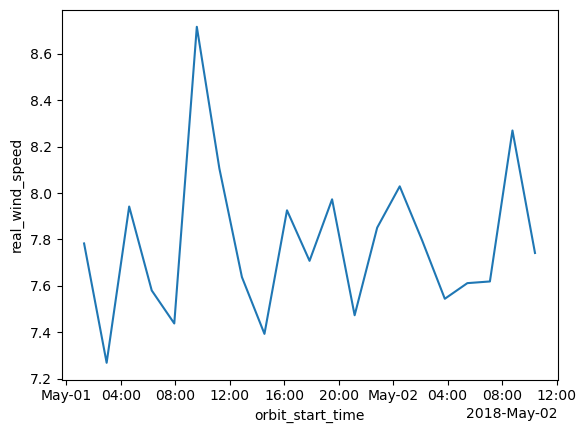

In [43]:
ts.plot()

### 3.3.2 icechunk

In [33]:
def get_icechunk_repo_local(repo_path: str, ea_creds: Optional[dict] = None):
    """
    Accesses a local icechunk repo and optionally appends Earthdata credentials to it.

    Inputs
    ------
    * repo_path (str): Path to icechunk repo.
    * ea_creds (dict, optional): Should contain values for 'accessKeyId', 'secretAccessKey', and 
        'sessionToken'.
    """
    
    storage = icechunk.local_filesystem_storage(path=repo_path)
    config = icechunk.RepositoryConfig.default()
    config.set_virtual_chunk_container(icechunk.VirtualChunkContainer("s3", "s3://", icechunk.s3_store(region="us-west-2")))
    repo_config = dict(
        storage=storage,
        config=config,
    )
    
    if ea_creds:
        earthdata_credentials = icechunk.containers_credentials(
            s3=icechunk.s3_credentials(
                access_key_id=ea_creds['accessKeyId'],
                secret_access_key=ea_creds['secretAccessKey'],
                session_token=ea_creds['sessionToken']
            )
        )
        repo_config['virtual_chunk_credentials'] = earthdata_credentials
        
    return icechunk.Repository.open(**repo_config)

In [34]:
## Access repo with earthaccess credentials added:
ea_creds = earthaccess.get_s3_credentials(daac='PODAAC')
repo = get_icechunk_repo_local(repo_path="vds_icechunk_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1", ea_creds=ea_creds)
session = repo.readonly_session(branch="main")

In [35]:
## Use it to open data on Earthdata:
data = xr.open_zarr(
    session.store,
    zarr_format=3,
    consolidated=False,
    chunks={},
)
data

/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:

<xarray.Dataset> Size: 67GB
Dimensions:                        (orbit_start_time: 1000, along_track: 3248,
                                    cross_track: 152)
Coordinates:
  * orbit_start_time               (orbit_start_time) datetime64[ns] 8kB 2018...
    lat                            (along_track, cross_track) float32 2MB dask.array<chunksize=(812, 76), meta=np.ndarray>
    lon                            (along_track, cross_track) float32 2MB dask.array<chunksize=(812, 76), meta=np.ndarray>
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    cross_track_wind_speed_bias    (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction              (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed_error            (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed_uncorrected      (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed                  (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    distance_from_coast            (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    wind_stress_direction          (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v_error            (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    time                           (orbit_start_time, along_track) datetime64[ns] 26MB dask.array<chunksize=(1, 3248), meta=np.ndarray>
    wind_stress_u                  (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v                  (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u_error            (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    standard_name_vocabulary:  CF Standard Name Table v78
    project:                   MEaSUREs/M17-0095
    summary:                   This project is funded by NASA’s Making Earth ...
    program:                   MEaSUREs
    references:                Hristova-Veleva, S., et al. 2017. https://eart...
    ...                        ...
    geospatial_lat_max:        89.99N
    geospatial_lon_min:        0.00E
    geospatial_lon_max:        359.99E
    time_coverage_duration:    P0DT1H41M0S
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    platform:                  SCATSAT-1

In [36]:
starttime = np.datetime64("2018-05-01T00:00:00") 
endtime = np.datetime64("2018-05-02T12:00:00")
data.sel(orbit_start_time=slice(starttime, endtime))

<xarray.Dataset> Size: 1GB
Dimensions:                        (orbit_start_time: 21, along_track: 3248,
                                    cross_track: 152)
Coordinates:
  * orbit_start_time               (orbit_start_time) datetime64[ns] 168B 201...
    lat                            (along_track, cross_track) float32 2MB dask.array<chunksize=(812, 76), meta=np.ndarray>
    lon                            (along_track, cross_track) float32 2MB dask.array<chunksize=(812, 76), meta=np.ndarray>
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    cross_track_wind_speed_bias    (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction              (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed_error            (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed_uncorrected      (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed                  (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    distance_from_coast            (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    wind_stress_direction          (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v_error            (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    time                           (orbit_start_time, along_track) datetime64[ns] 546kB dask.array<chunksize=(1, 3248), meta=np.ndarray>
    wind_stress_u                  (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v                  (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u_error            (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    standard_name_vocabulary:  CF Standard Name Table v78
    project:                   MEaSUREs/M17-0095
    summary:                   This project is funded by NASA’s Making Earth ...
    program:                   MEaSUREs
    references:                Hristova-Veleva, S., et al. 2017. https://eart...
    ...                        ...
    geospatial_lat_max:        89.99N
    geospatial_lon_min:        0.00E
    geospatial_lon_max:        359.99E
    time_coverage_duration:    P0DT1H41M0S
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    platform:                  SCATSAT-1

In [37]:
%%time
#data.sel(orbit_start_time=slice(starttime, endtime))["real_wind_speed"].mean().compute()
ts = data.sel(orbit_start_time=slice(starttime, endtime))["real_wind_speed"].mean(dim=["along_track","cross_track"]).compute()

CPU times: user 246 ms, sys: 47.4 ms, total: 293 ms
Wall time: 905 ms


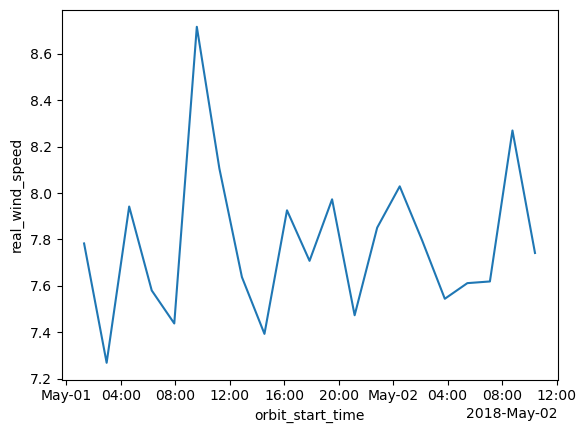

In [38]:
ts.plot()